# Tarea 2 - Procesamiento distribuido y redes neuronales profundas

In [94]:
import os 
import torch
import PIL
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from PIL import Image
from torchvision import datasets, transforms
from keras.applications.imagenet_utils import decode_predictions
from skimage.segmentation import slic, mark_boundaries
from skimage.io import imshow
from scipy.stats import bernoulli
%matplotlib inline
# Path del directorio
path_dir = os.getcwd()
# Se asigna un valor de reproductibilidad
torch.manual_seed(6202)
#np.random.seed(seed=6202)

In [2]:
path_dir

'/content'

## P3. Interpretabilidad 

### 1

In [154]:
preprocesamiento = transforms.Compose([transforms.Resize(size=299, interpolation=2),
                                     transforms.CenterCrop(299),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225], 
                                                          inplace=True)
                                     ])

### 2

In [14]:
modelo = torch.hub.load('pytorch/vision:v0.6.0', 'inception_v3', pretrained=True)
modelo.eval();

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

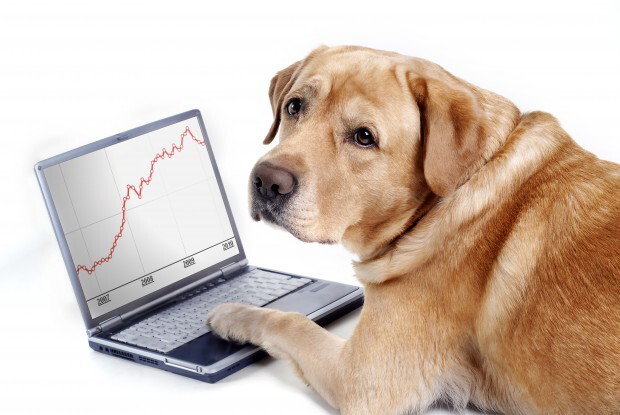

In [155]:
imagen_control = Image.open("imagen_control.jpg")
imagen_control

In [198]:
imagen_procesada = preprocesamiento(imagen_control)
imagen_procesada

tensor([[[ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
         [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
         [ 2.2318,  2.2318,  2.2318,  ...,  2.2318,  2.2318,  2.2318],
         ...,
         [ 2.2489,  2.2489,  2.2489,  ...,  0.2624,  0.3652,  0.3994],
         [ 2.2489,  2.2489,  2.2489,  ...,  0.2282,  0.3481,  0.3652],
         [ 2.2489,  2.2489,  2.2489,  ...,  0.1939,  0.2967,  0.3309]],

        [[ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
         [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
         [ 2.4111,  2.4111,  2.4111,  ...,  2.4111,  2.4111,  2.4111],
         ...,
         [ 2.4286,  2.4286,  2.4286,  ..., -0.0049,  0.0826,  0.1352],
         [ 2.4286,  2.4286,  2.4286,  ..., -0.0399,  0.0826,  0.1001],
         [ 2.4286,  2.4286,  2.4286,  ..., -0.0749,  0.0301,  0.0651]],

        [[ 2.6400,  2.6400,  2.6400,  ...,  2.6400,  2.6400,  2.6400],
         [ 2.6400,  2.6400,  2.6400,  ...,  2

In [157]:
imagen_procesada.shape

torch.Size([3, 299, 299])

In [158]:
# Se genera la red para procesar la imagen de control

input_batch = imagen_procesada.unsqueeze(0) # create a mini-batch as expected by the model

# mueve el input y modelo a la GPU en caso de estar disponible
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    modelo.to('cuda')

with torch.no_grad():
  output = modelo(input_batch)

# array of shape 1000, with confidence scores over Imagenet's 1000 classes
predicciones = output[0].numpy().reshape([-1,1]).T
#print(output[0])
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
#print(torch.nn.functional.softmax(output[0], dim=0))

La clase más probable es Labrador_retriever, con un score de confianza de 8.53

In [160]:
decode_predictions(predicciones)

[[('n02099712', 'Labrador_retriever', 8.534056),
  ('n03832673', 'notebook', 5.021486),
  ('n02087394', 'Rhodesian_ridgeback', 4.787019),
  ('n02099601', 'golden_retriever', 4.722912),
  ('n03642806', 'laptop', 4.4893384)]]

### 3

In [199]:
# Se reajustan las dimensiones de la imagen procesada
imagen_procesada = np.transpose(imagen_procesada.numpy(),[1,2,0])
imagen_procesada.shape
#img = Image.fromarray(np.transpose(imagen_procesada.numpy(),[1,2,0]), 'RGB')
#img.shape

(299, 299, 3)

In [201]:
imagen_segmentada = slic(imagen_procesada,n_segments=80)
#imagen_segmentada = slic(imagen_control, n_segments=80)
imagen_segmentada.shape

(299, 299)

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


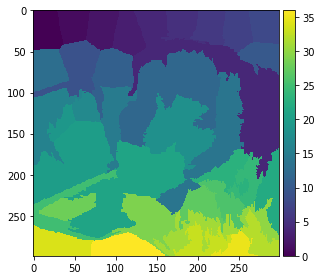

In [202]:
# Visualizamos primero los labels de la segmentación
imshow(imagen_segmentada)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


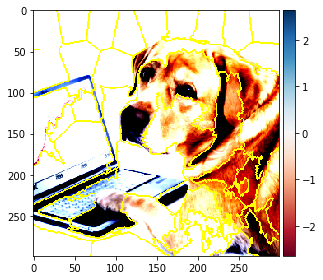

In [204]:
# Visualizamos la imagen de control con los bordes inducidos por los superpixeles. 
imshow(mark_boundaries(image=imagen_procesada,label_img=imagen_segmentada))

### 4

In [205]:
# Obtenemos los label únicos.
print(np.unique(imagen_segmentada))
# Notamos que van de 0 a 36. Luego son un total de 37 labels.
unique_labels = 37

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36]


In [207]:
# Número de perturbaciones a realizar
n_perturbaciones = 1000 

# Se construye el arreglo de perturbaciones
perturbaciones = np.array([np.array(bernoulli.rvs(0.5, loc=0, size=unique_labels)) for i in range(n_perturbaciones)])

# Notamos que son 1000 perturbaciones distintas para los 62 labels
print(perturbaciones.shape)

# Vemos una de las perturbaciones
print(perturbaciones[0])

(1000, 37)
[0 1 1 1 0 1 0 1 0 0 0 1 0 1 0 0 0 1 0 1 0 1 1 1 0 1 0 0 0 1 1 0 0 0 0 0 0]


### 5

In [208]:
perturbacion = perturbaciones[0]
imagen_segmentada

array([[ 0,  0,  0, ...,  8,  8,  8],
       [ 0,  0,  0, ...,  8,  8,  8],
       [ 0,  0,  0, ...,  8,  8,  8],
       ...,
       [34, 34, 34, ..., 32, 32, 32],
       [34, 34, 34, ..., 32, 32, 32],
       [34, 34, 34, ..., 32, 32, 32]])